<a href="https://colab.research.google.com/github/charann90/SGEMM-GPU-Kernel-Performance/blob/main/SGEMM_GPU_Kernel_Performance_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the running times for multiplying two 2048 x 2048 matrices using a GPU OpenCL SGEMM kernel with varying parameters (using the library 'CLTune'). </u></b>

## <b> Problem Description </b>

### This data set measures the running time of a matrix-matrix product $A*B = C$, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*.

### There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

### The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' ([Web Link]).

#### * Note: for this kind of data sets it is usually better to work with the logarithm of the running times 


## <b> Data Description </b>

### <b>Attribute Information: </b>

### Independent variables:
* ### MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
* ### KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
* ### MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
* ### MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
* ### KWI: kernel loop unrolling factor: {2, 8} (integer)
* ### VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
* ### STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
* ### SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

### Output:
* ### Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

Libraries

# Libraries



In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor

# Data uploading

In [23]:
path='/content/sgemm_product.csv'
df=pd.read_csv(path)

In [24]:
#reading the top contents of the dataframe
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


# Data wrangling

In [25]:
#getting the summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MWG        241600 non-null  int64  
 1   NWG        241600 non-null  int64  
 2   KWG        241600 non-null  int64  
 3   MDIMC      241600 non-null  int64  
 4   NDIMC      241600 non-null  int64  
 5   MDIMA      241600 non-null  int64  
 6   NDIMB      241600 non-null  int64  
 7   KWI        241600 non-null  int64  
 8   VWM        241600 non-null  int64  
 9   VWN        241600 non-null  int64  
 10  STRM       241600 non-null  int64  
 11  STRN       241600 non-null  int64  
 12  SA         241600 non-null  int64  
 13  SB         241600 non-null  int64  
 14  Run1 (ms)  241600 non-null  float64
 15  Run2 (ms)  241600 non-null  float64
 16  Run3 (ms)  241600 non-null  float64
 17  Run4 (ms)  241600 non-null  float64
dtypes: float64(4), int64(14)
memory usage: 33.2 MB


In [26]:
#creating a new column 'runtime' with respect to other columns
df['runtime']=df[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis=1)

Merging all the 4 run into a 'runtime column with mean value of all the 4 run columns and dropping them there after

# checking null values

In [27]:
df.isnull().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
runtime      0
dtype: int64

There are no null values in the dataset

# EDA

In [28]:
#understanding the statistical information of data using describe method
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MWG,241600.0,80.415364,42.469220,16.0000,32.0000,64.000,128.0000,128.0000
NWG,241600.0,80.415364,42.469220,16.0000,32.0000,64.000,128.0000,128.0000
KWG,241600.0,25.513113,7.855619,16.0000,16.0000,32.000,32.0000,32.0000
MDIMC,241600.0,13.935894,7.873662,8.0000,8.0000,8.000,16.0000,32.0000
NDIMC,241600.0,13.935894,7.873662,8.0000,8.0000,8.000,16.0000,32.0000
MDIMA,241600.0,17.371126,9.389418,8.0000,8.0000,16.000,32.0000,32.0000
NDIMB,241600.0,17.371126,9.389418,8.0000,8.0000,16.000,32.0000,32.0000
KWI,241600.0,5.000000,3.000006,2.0000,2.0000,5.000,8.0000,8.0000
VWM,241600.0,2.448609,1.953759,1.0000,1.0000,2.000,4.0000,8.0000
VWN,241600.0,2.448609,1.953759,1.0000,1.0000,2.000,4.0000,8.0000


**We can notice that for 'runtime' data, the first 3 quartiles are 40, 70 and 229 respectively. But some of our values reach to the far end of 3341**

In [29]:
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),runtime
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81,118.6625


In [30]:
#dropping all the run columns as it's mean value has been used
df.drop(columns=['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'],inplace=True)

In [31]:
pd.concat([df[col].value_counts() for col in df], axis = 1)


,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,runtime
0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120800.0,120800.0,120800.0,120800.0,NaN
1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99808.0,99808.0,120800.0,120800.0,120800.0,120800.0,NaN
2.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120800.0,75584.0,75584.0,NaN,NaN,NaN,NaN,NaN
4.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47264.0,47264.0,NaN,NaN,NaN,NaN,NaN
8.0000,NaN,NaN,NaN,124928.0,124928.0,85696.0,85696.0,120800.0,18944.0,18944.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334.8375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3335.1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3335.3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3339.4675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


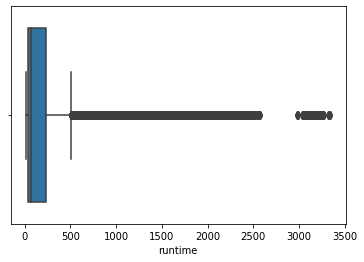

In [32]:
#plotting the newly created column 'runtime' for getting outliers
sns.boxplot(df['runtime'])
plt.show()

From the above plot we can deduce that there are no extreme outliers and that the entire data is usefull.

In [33]:
#getting all the unique value of all the columns
df.apply(lambda x: len(x.unique()))

MWG             4
NWG             4
KWG             2
MDIMC           3
NDIMC           3
MDIMA           3
NDIMB           3
KWI             2
VWM             4
VWN             4
STRM            2
STRN            2
SA              2
SB              2
runtime    131488
dtype: int64

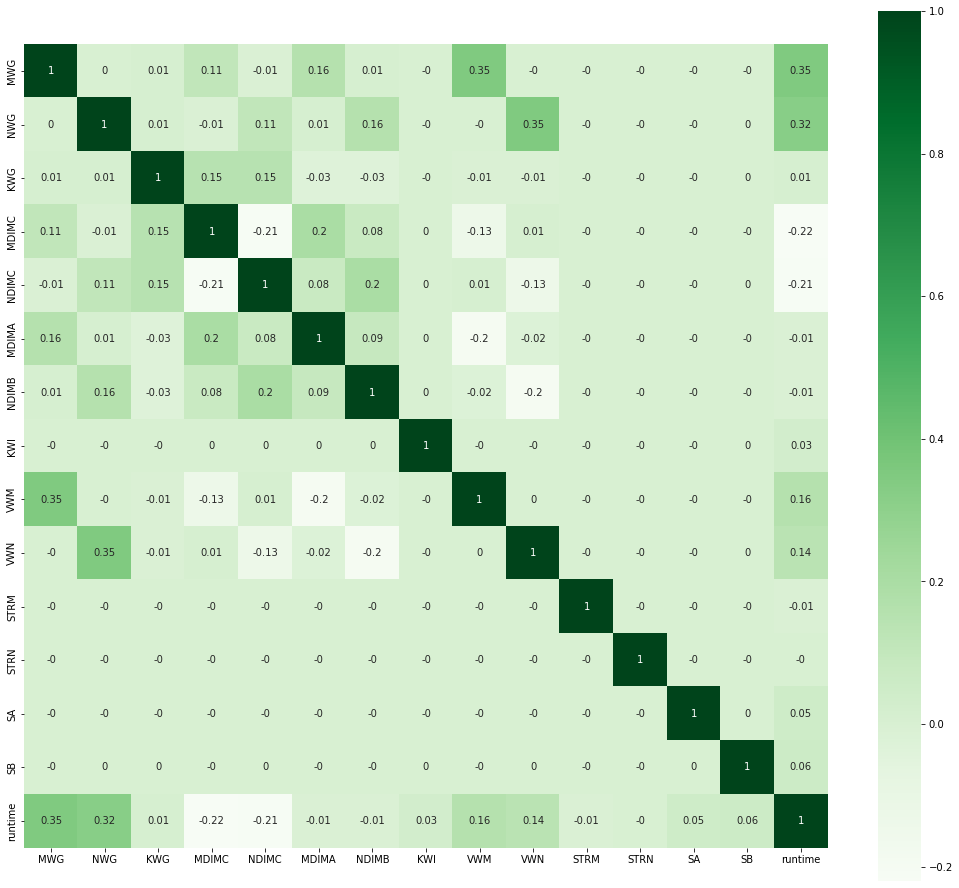

In [34]:
#checking the correlation of the columns by heat map
plt.figure(figsize=(18,16))
sns.heatmap(round(df.corr(),2),cmap='Greens',square=True,annot=True)
plt.show()

 No Significant correlation found with max at 0.35, hence we have a good data

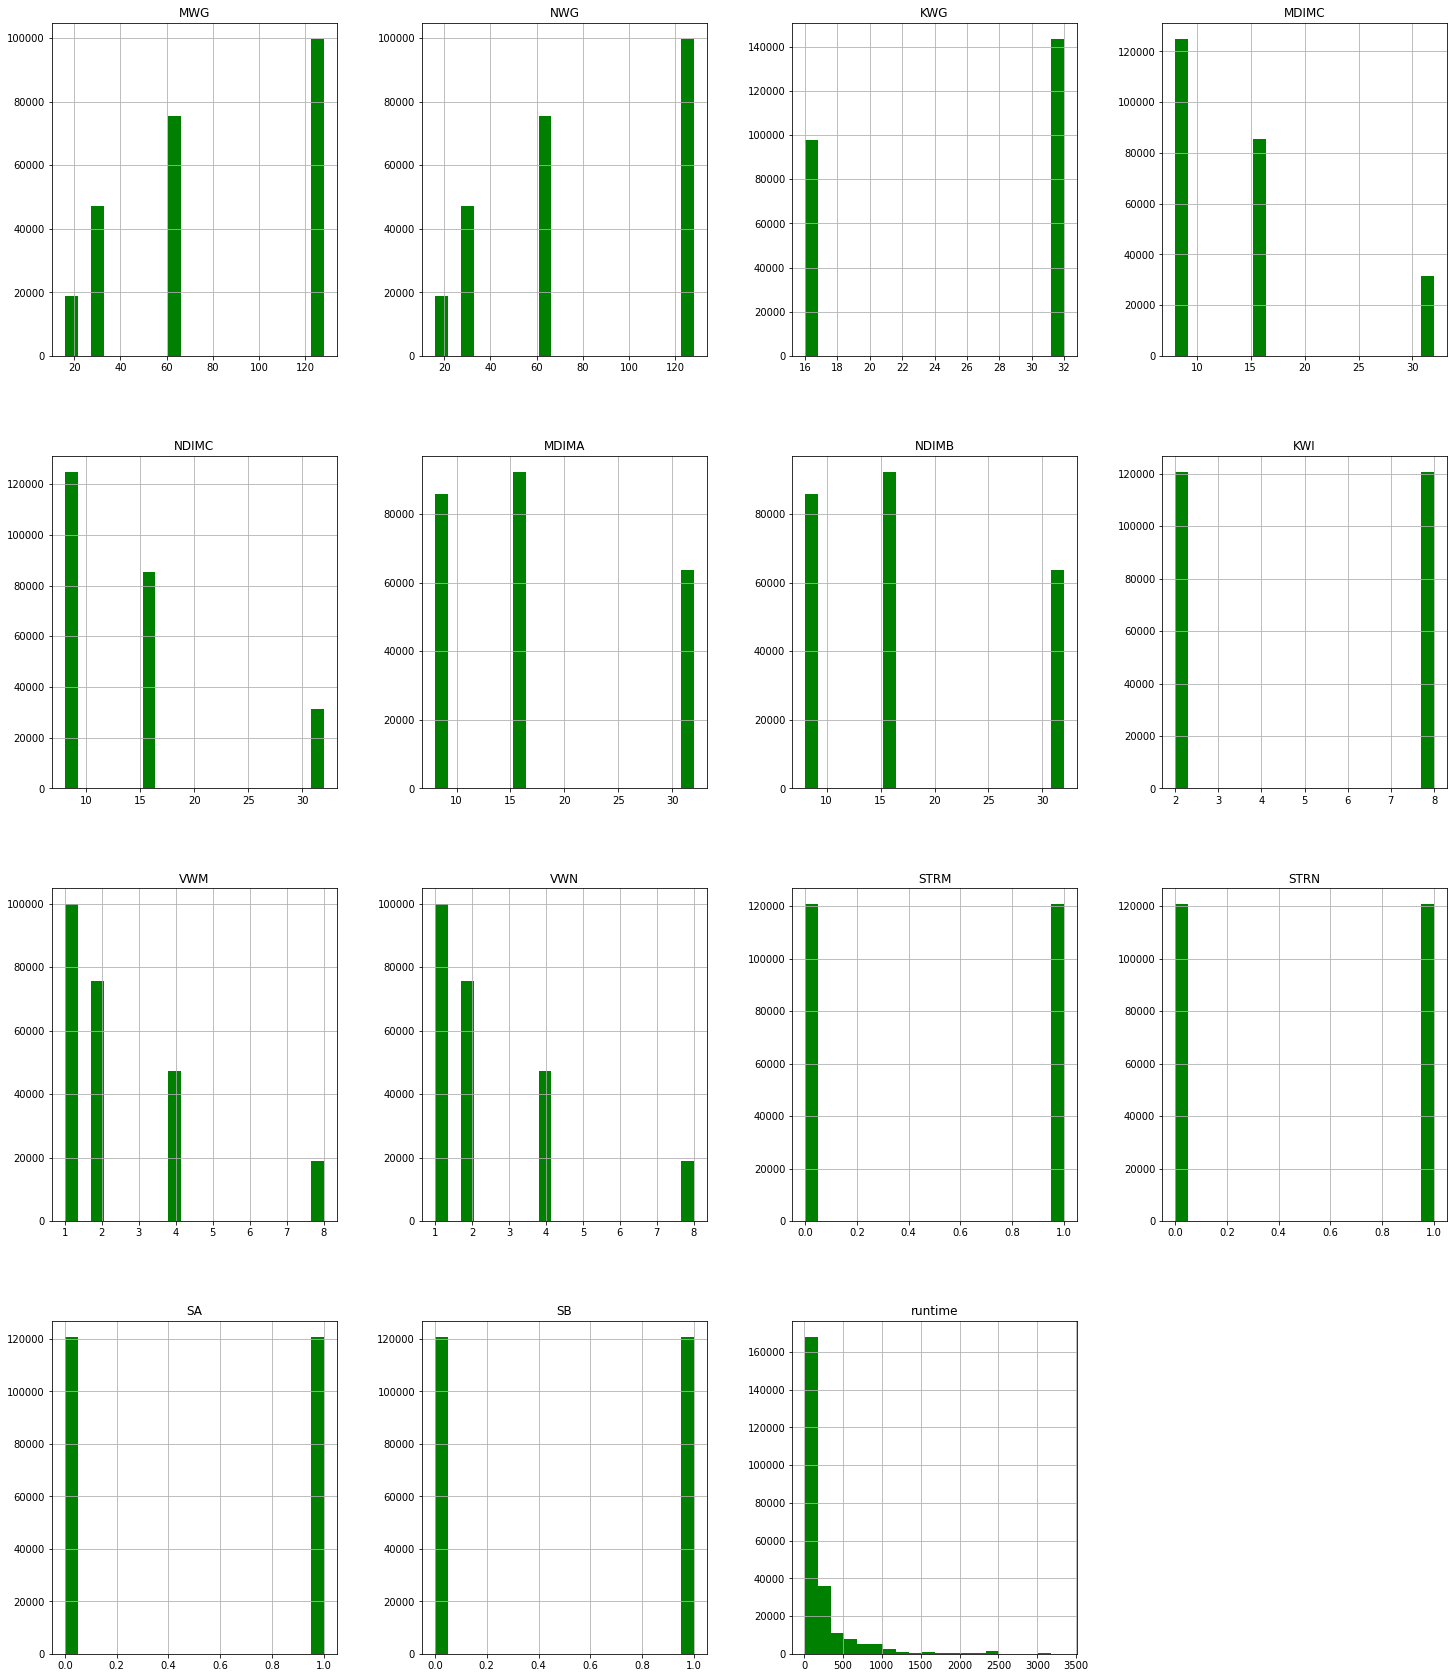

In [35]:
#creating histogram for every column
df.hist(bins=20, color='Green', figsize=(25,30))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


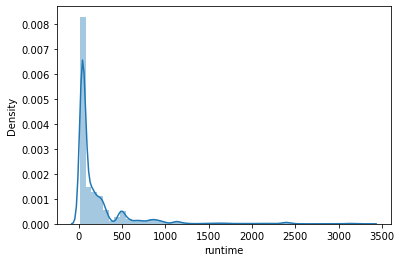

In [36]:
#checking skewness of 'runtime'
sns.distplot(df['runtime'])
plt.show()

In [37]:
#Transforming 'runtime' data by scaling it with log values for normalisation
df['truntime']=np.log(df['runtime'])

In [38]:
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,runtime,truntime
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700,4.756775
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050,4.365707
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650,4.389064
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375,4.461733
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625,4.776283


In [39]:
#dropping 'runtime' as it is unnecessory now
df.drop(columns=['runtime'],inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


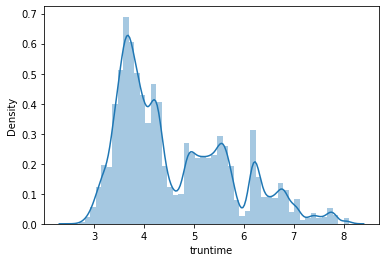

In [40]:
sns.distplot(df['truntime'])
plt.show()

Now data looks normalized

In [41]:
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,truntime
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,4.756775
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,4.365707
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,4.389064
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,4.461733
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,4.776283


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

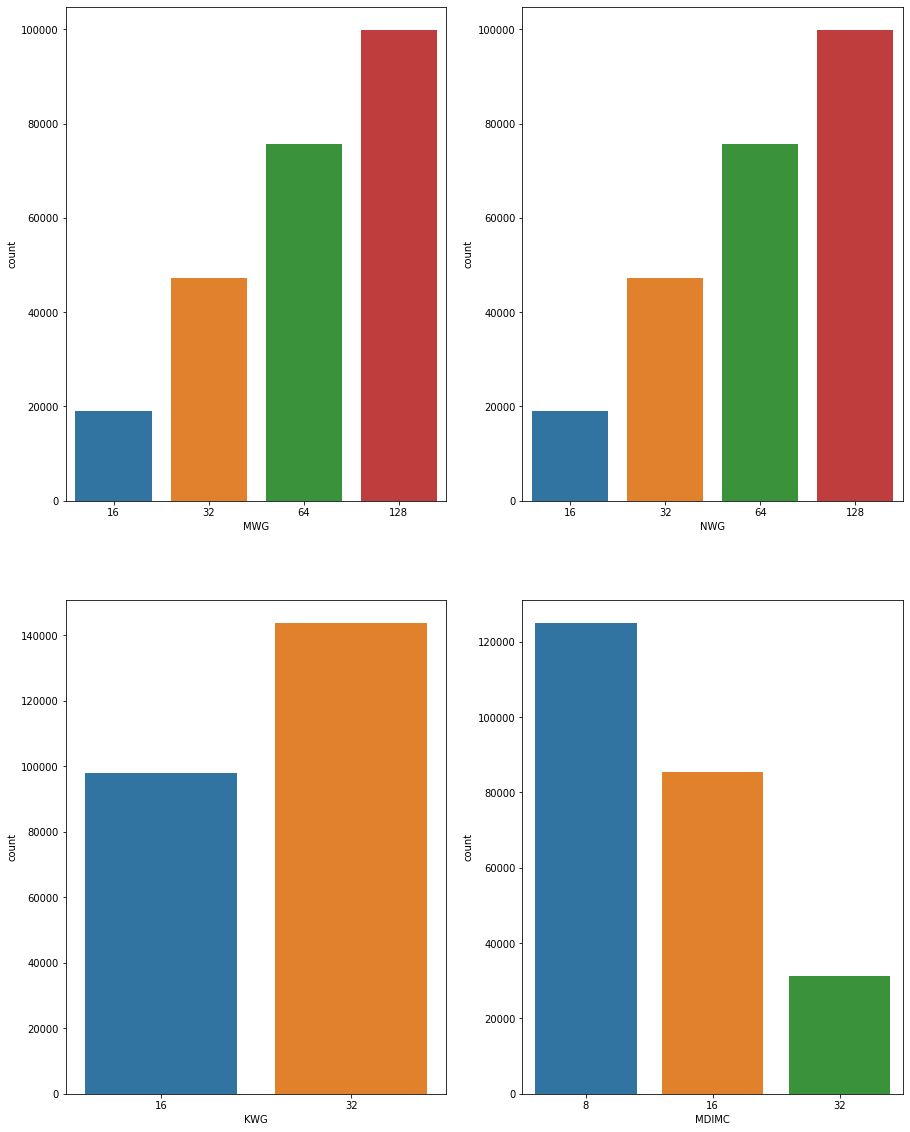

In [42]:
#plotting the density of all the unique values of different features
fig,ax = plt.subplots(2,2,figsize = (15,20))
for i,countplots in zip (df , ax.flatten()):
  sns.countplot(df[i],ax = countplots)
plt.show()

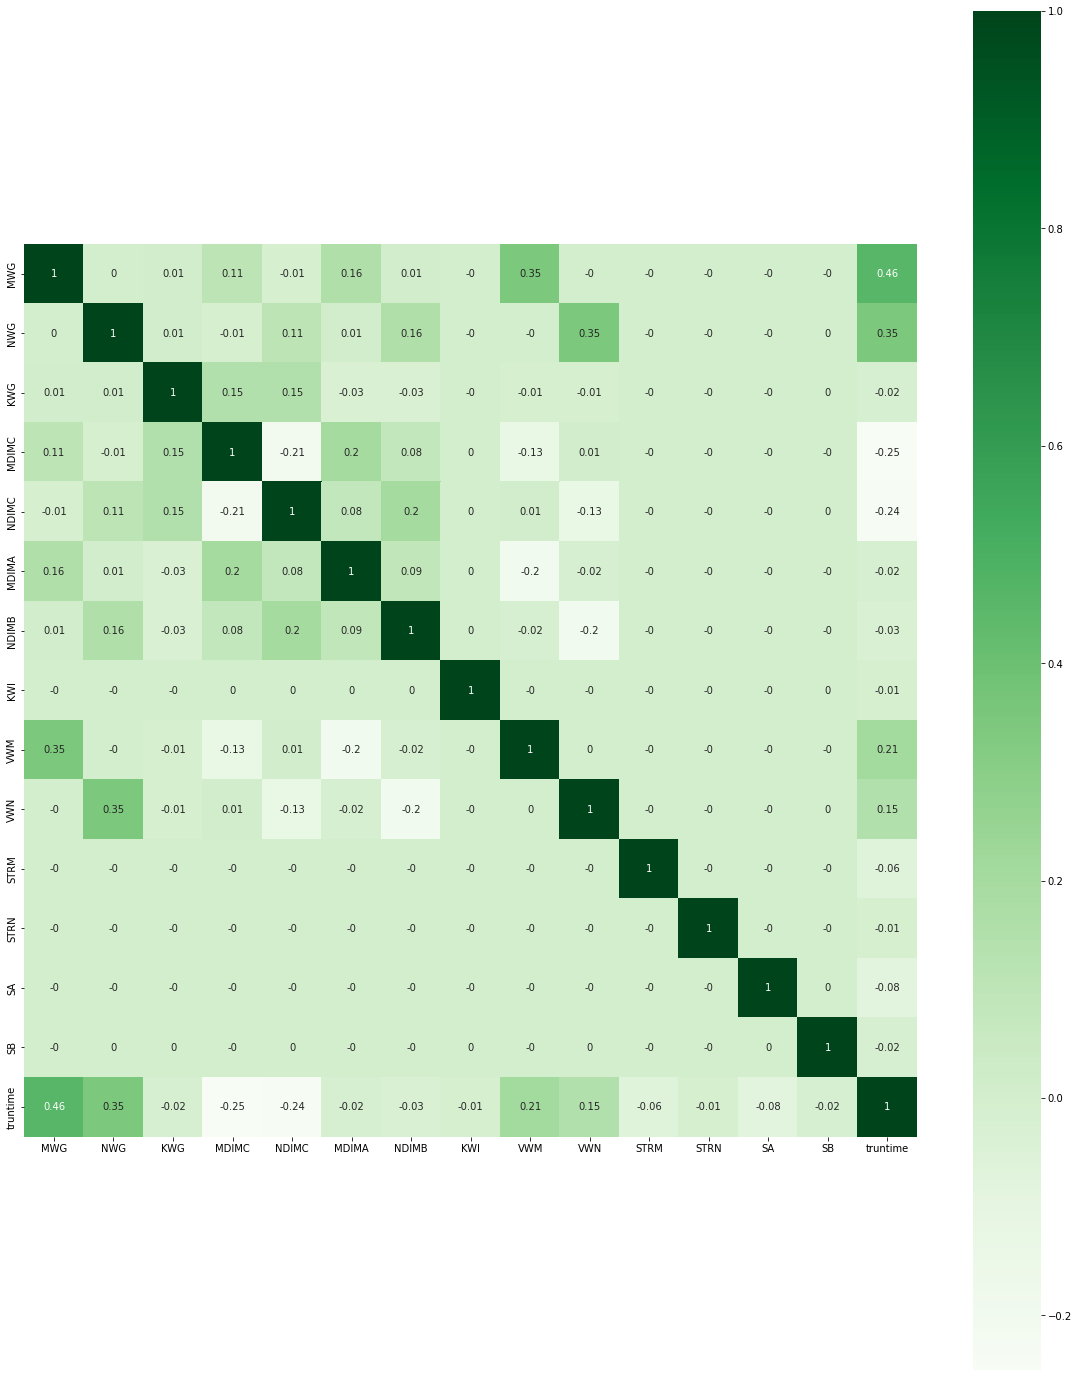

In [43]:
#now checking the correlation if the transformation is successfull and finding correlation
plt.figure(figsize=(20,25))
sns.heatmap(round(df.corr(),2),cmap='Greens',square=True,annot=True)
plt.show()

From the above heatmap we can conclude  that MWG and NWG is strongly correlated to truntime 

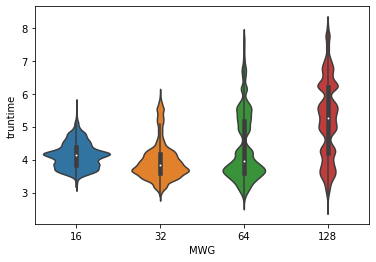

In [44]:
sns.violinplot(data = df, x='MWG', y='truntime')

Since 'MWG' has strong correlation with 'Truntime', the  relatio is best known by voilin plot

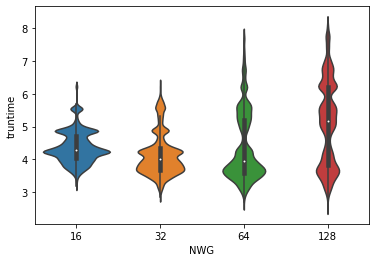

In [45]:
sns.violinplot(data = df, x='NWG', y='truntime')

Since 'NWG' has strong correlation with 'Truntime', the  relatio is best known by voilin plot

In [46]:
#getting the catogorical count of column 'KWG'
df['KWG'].value_counts()

32    143648
16     97952
Name: KWG, dtype: int64

# Machine Learning

# Test and train split

In [47]:
#seperating the data into both testing and training data with tst size limit to 30%
x=df.loc[:,df.columns!='truntime']
y=df.loc[:,df.columns == 'truntime']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3, random_state=0)

In [48]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((169120, 14), (72480, 14), (169120, 1), (72480, 1))

In [49]:
#calling a function R2_cal 
def R2_cal(test,pred) :
  r2 = r2_score(y_test, y_pred)
  adj_r2 = 1-(1-r2)*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1))
  print(f"R2 Score : {r2}\nAdjusted R2 Score : ,{adj_r2}")

Logistic regression is not suitable since 'truntime' column variable are float type

# Linear Regression

In [50]:
#defining a linear regression variable
linear_reg=LinearRegression()
linear_reg.fit(x_train,y_train)

LinearRegression()

In [51]:
#prediction from x_test
y_pred=linear_reg.predict(x_test)

In [52]:
y_pred

array([[5.6074595 ],
       [4.36864838],
       [4.75528985],
       ...,
       [5.36732668],
       [6.53767926],
       [2.68919505]])

In [53]:
#getting the intercept  
linear_reg.intercept_

array([4.22494139])

In [54]:
linear_reg.coef_

array([[ 1.33746138e-02,  1.05535882e-02,  1.25744806e-02,
        -5.68608494e-02, -5.46862131e-02,  1.22071254e-04,
        -2.27648529e-05, -3.86028769e-03, -8.60218870e-03,
        -2.35893820e-02, -1.33958244e-01, -1.67630345e-02,
        -1.88864941e-01, -4.70807275e-02]])

In [55]:
#creating a data frame for actual and predicted values
df_pred=pd.DataFrame({'actual':y_test.squeeze(),'predicted':y_pred.squeeze()})

In [56]:
df_pred

,actual,predicted
111345,6.730866,5.607460
62516,3.565298,4.368648
143068,4.220647,4.755290
152967,3.720257,4.805568
223400,6.205618,6.138654
...,...,...
232773,5.370243,5.718069
61934,3.898583,4.683134
224785,5.173802,5.367327
219261,7.547532,6.537679


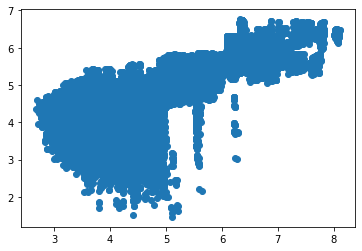

In [57]:
#plotting the distribution of actual and predicted in the form of scatter plot
plt.scatter(y_test,y_pred)
plt.show()

R2 score and adjusted R2 score

In [58]:
R2_cal(y_test,y_pred)

R2 Score : 0.5572992430108776
Adjusted R2 Score : ,0.5572137146786089


# Lasso Regression

In [59]:
#defining lasso function 
lasso=Lasso(alpha=0.001)
lasso.fit(x_train,y_train)

Lasso(alpha=0.001)

In [60]:
#predicting outputs from the x_test
y_pred=lasso.predict(x_test)

In [61]:
y_pred

array([5.60264757, 4.36662395, 4.75521942, ..., 5.36242402, 6.53974784,
       2.69026239])

In [62]:
#creating a data frame containing both actual and predicted values
df_pred=pd.DataFrame({'actual':y_test.squeeze(),'predicted':y_pred.squeeze()})

In [63]:
df_pred

,actual,predicted
111345,6.730866,5.602648
62516,3.565298,4.366624
143068,4.220647,4.755219
152967,3.720257,4.810395
223400,6.205618,6.134303
...,...,...
232773,5.370243,5.719099
61934,3.898583,4.685202
224785,5.173802,5.362424
219261,7.547532,6.539748


R2 score and Adjusted R2 score

In [64]:
R2_cal(y_test,y_pred)

R2 Score : 0.5572777114979244
Adjusted R2 Score : ,0.5571921790058381


# Ridge Regression- Checking multicollinearity.

In [65]:
ridge=Ridge()
ridge.fit(x_train,y_train)

Ridge()

In [66]:
y_pred=ridge.predict(x_test)

In [67]:
y_pred

array([[5.6074559 ],
       [4.36864448],
       [4.75528883],
       ...,
       [5.36732319],
       [6.53767911],
       [2.68919621]])

# R2 score and Adjusted R2 score

In [68]:
R2_cal(y_test,y_pred)

R2 Score : 0.5572992351925502
Adjusted R2 Score : ,0.557213706858771


# Decision Tree

In [69]:
#defining a variable for decision tree regression
tree_reg= DecisionTreeRegressor()
tree_reg.fit(x_train,y_train)

DecisionTreeRegressor()

In [70]:
y_pred=tree_reg.predict(x_test)

In [71]:
y_pred

array([6.72420497, 3.56480322, 4.21947094, ..., 5.17516054, 7.55223335,
       3.92023916])

R2 score and Adjusted R2 score

In [72]:
R2_cal(y_test,y_pred)

R2 Score : 0.9989008173794302
Adjusted R2 Score : ,0.9989006050209579


R2 score of Decision Tree Regression is more compared to other logarithms

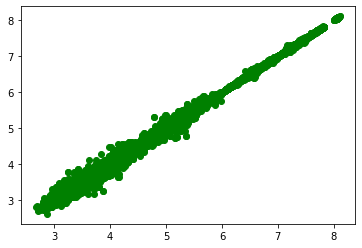

In [73]:
#checking Linearity Graphically
plt.scatter(y_test,y_pred, color='green')
plt.show()

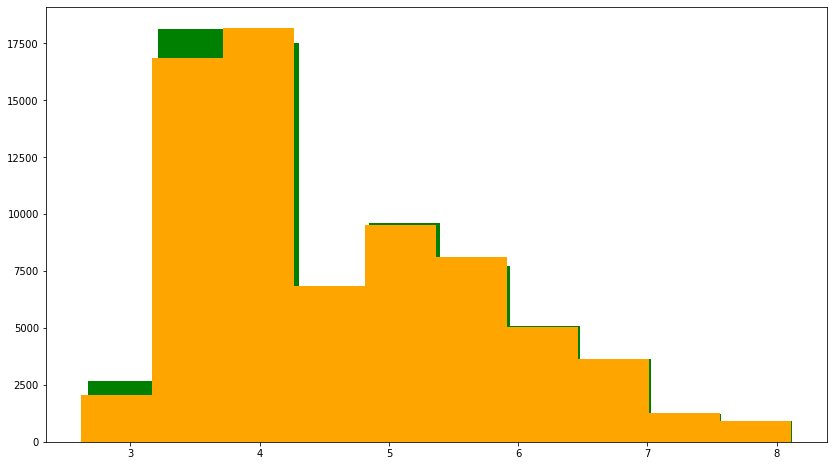

In [74]:
#checking data fit by plotting histograms of actual and predicted 
plt.figure(figsize=(14,8))
plt.hist(np.array(y_test),color='green')
plt.hist(y_pred,color='orange')
plt.show()

# Random forest Regression

In [75]:
random_reg= RandomForestRegressor()

In [76]:
random_reg.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor()

In [77]:
y_pred = random_reg.predict(np.array(x_test))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


In [78]:
y_pred

array([6.72558503, 3.56815079, 4.22070117, ..., 5.17014621, 7.55336675,
       3.96050915])

In [79]:
R2_cal(y_test,y_pred)

R2 Score : 0.9992660793811396
Adjusted R2 Score : ,0.9992659375900865


Random forest regression also has high accuracy of R2 score and adjusted R2 score,that is ~0.99

In [80]:
#Deciding the importance of features of the dataframe
importance=tree_reg.feature_importances_
importance

array([0.29014524, 0.23343581, 0.01364043, 0.16839145, 0.20555014,
       0.00117443, 0.00116873, 0.0039592 , 0.01423786, 0.00821436,
       0.01220694, 0.00143012, 0.0283029 , 0.01814239])

In [81]:
feature_names= list(x.columns)

In [82]:
#creating a dataframe for the features and its importance
tree_imp=pd.DataFrame(columns=['variable','importance'])
tree_imp.variable= feature_names
tree_imp.importance= importance
tree_imp

,variable,importance
0,MWG,0.290145
1,NWG,0.233436
2,KWG,0.013640
3,MDIMC,0.168391
4,NDIMC,0.205550
5,MDIMA,0.001174
6,NDIMB,0.001169
7,KWI,0.003959
8,VWM,0.014238
9,VWN,0.008214


In [83]:
#plotting the importance of the variables color bar graph
fig = px.bar(tree_imp, y = 'variable', 
       x = 'importance',
       labels = {'variable':'Varible Name','importance':'Affect on performance'},
       color = 'importance', 
       title = 'Variable vs Importance', 
       text = 'importance' ,
       color_continuous_scale=px.colors.qualitative.Plotly)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

# **Conclusion**
* Logrithmic Regression - Not applicable for this dataset since target variable is Float type

* Linear regression - Not suitable since adjusted R2 score = 0.55
* Lasso regression - Not suitable since adjusted R2 score = 0.55
* Ridge regression - Not suitable since adjusted R2 score = 0.55

**Decission Tree Regression - Ideal model with adjusted R2 score = 0.99**

**Random tree Regression- Ideal model with adjusted R2 score= 0.99**

---


 >It was found that the runtime of SGEMM GPU kernel is highly depeding upon selection and values of parameters passed.



\begin{array}{|c|c|}\hline\\
Variable & Importance \\ \hline\\
MWG               & .290\\ \hline\\
NWG               & .232\\ \hline\\
KWG               & .013\\ \hline\\
MDIMC             & .168\\ \hline\\
NDIMC             & .205\\ \hline\\
MDIMA             & .001\\ \hline\\
NDIMB             & .001\\ \hline\\
KWI               & .003\\ \hline\\
VWM               & .014\\ \hline\\
VWN               & .008\\ \hline\\
STRM              & .012\\ \hline\\
STRN              & .001\\ \hline\\
SA                & .028\\ \hline\\
SB                & .018\\ \hline \end{array}